# xG Playground - Build Your Own Model

If you think you can build a better opponent-aware xG model then us - you're probably right! 

Use this notebook to build your own and benchmark against ours. Then if you know beginner Javascript, drop your model into your own interactive web app to fully test it out. Check out https://github.com/sharmaabhishekk/Interactive-freeze-frames-xg for the web app code.

First install TensforFlow.js - https://www.tensorflow.org/js

We need this to convert our model to Javascript form that can be called by a web app

In [1]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 4.0 MB/s 


Import all requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

import tensorflowjs as tfjs

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

tf.config.run_functions_eagerly(True)

Go to https://github.com/opengoalapp/ConvNets/tree/master/data and download a preprocessed snapshot of Statsbomb's open shot freeze frame data from June 2020.

Place the two files in a folder on your drive called "convnet_data" - or anything you like and then change the code below accordingly

In [ ]:
loaded = np.load('/content/drive/MyDrive/convnet_data/input_compressed.npz')
DataIn = loaded['a']
DataOut = pd.read_pickle("/content/drive/MyDrive/convnet_data/output_arrays.pkl")

DataIn = DataIn.astype('float32')

Verify the shape of the input data to confirm we have around 18,000 shots described as 3-channel binary arrays.

See https://www.opengoalapp.com/xg-with-cnns-full-study for details of this notation.

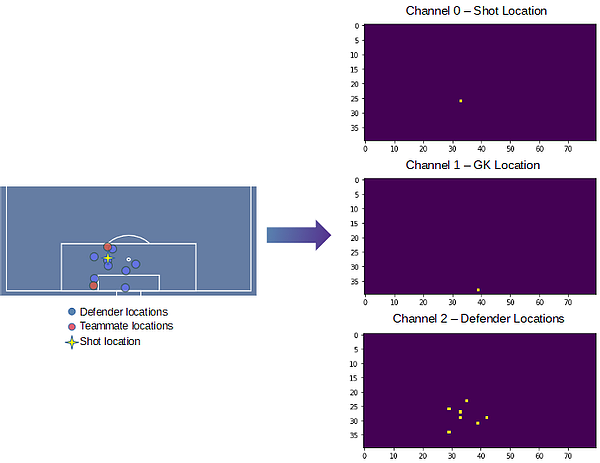

In [ ]:
DataIn.shape

(17975, 40, 80, 3)

Next we can inspect the output dataframe we imported. We'll only be using `shot_outcome` for model training. But with the additonal fields we can sanity check any model outputs with the Statsbomb xG for the shot.

In [ ]:
DataOut.head()

,shot_outcome,statsbomb_xg,team
id,,,
00007fd2-738e-4b27-bb68-7bdeffc77ee7,0,0.020466,Espanyol
00042e9f-890a-4e6a-9f54-702dd9b012d9,0,0.020076,Manchester City WFC
00063980-fd46-4b06-8eff-58916206ae80,1,0.154954,Reading WFC
0006c5eb-7d26-460d-b073-341302cac818,0,0.131828,Bristol City WFC
001bbff8-5927-44ba-9a78-1cca93f009b6,0,0.083931,France


This version of the model uses 4 helper columns which aim to help the model "understand" the relationship between a shot situation and xG a bit better with the data we have.

These columns are:

* The distance between the ball and the goal centre
* The angle between the ball and goal centre
* The distance between the goalkeeper and the goal centre
* The angle between the goalkeeper and goal centre

This doesn't give us any additonal information that isn't contained in the binary arrays, but it tells the model-up front things about the shot situation we know are important and can help stabilize the model to give realistic outputs for a wider array of input scenarios at prediction time.

So these new inputs can now be generated 





In [ ]:
# x distance from ball to goal line
x_dists = np.array([40 - np.nonzero(DataIn[i,:,:,0])[0][0] for i in range(len(DataIn))])

# y abs distance from ball loc to goal centre
y_dists = np.array([abs(40 - np.nonzero(DataIn[i,:,:,0])[1][0]) for i in range(len(DataIn))]) # we'll mirror the angle for y positions > 40

# It is slightly more involved to do the same for the GK frames, as some frames don't have a goalkeeper in them! For those shots we will say the GK is present but completely out of the way.
gkx_dists = []
gky_dists = []
for i in range(len(DataIn)):
  try:
    x = 40 - np.nonzero(DataIn[i,:,:,1])[0][0]
    y = abs(40 - np.nonzero(DataIn[i,:,:,1])[1][0]) 
  except IndexError: # No keeper in frame - set to corner flag
    x = 0.1
    y = 40

  gkx_dists.append(x)
  gky_dists.append(y)

gkx_dists = np.array(gkx_dists)
gky_dists = np.array(gky_dists)

# From the x,y distances calculate the straight line distance and angle
dists = (x_dists**2 + y_dists**2)**0.5
angles = np.arctan2(y_dists, x_dists)

gk_dists = (gkx_dists**2 + gky_dists**2)**0.5
gk_angles = np.arctan2(gky_dists, gkx_dists)

# Convert to a (,4) array
AuxIn = np.vstack((dists, angles, gk_dists, gk_angles)).T

We can now prepare the data for model training and testing. Here we'll use a 75-25 train-test split.

In [ ]:
# split data into train and test
x_train, x_test, xaux_train, xaux_test, out_train, out_test = train_test_split(DataIn, AuxIn, DataOut, test_size=0.25, random_state=42)

x_test = np.float32(x_test)
x_train = np.float32(x_train)
xaux_train = np.float32(xaux_train)
xaux_test = np.float32(xaux_test)

# We only want the shot outcome for training, but we do this after the split so we have the correct statsbomb xG for each shot
y_train = out_train.loc[:, 'shot_outcome'].values.astype('float32') 
y_test = out_test.loc[:, 'shot_outcome'].values.astype('float32')

Let's build the model. The architecture below is implemented on xgplayground.com. You can try changing some of the parameters or completely rebuild from the ground up.

In [ ]:
# Specify the activation function for the bulk of the layers
activation = tf.keras.layers.LeakyReLU(alpha=0.1) # Important here as the network is 5 layers deep

# Specify our two inputs: the 3-channel binary image input and the ball/GK location helper input
input_img = Input(shape=(40, 80, 3), dtype='float32')
input_aux = Input(shape=(4), dtype='float32')

# The pathway for the helper inputs is just a simple logisitc regression 
output_naive = Dense(1, activation='sigmoid', name = 'naive')(input_aux) # naive xG

# Define main CNN blocks
block1 = Conv2D(32, (5, 5), activation=activation, padding='same')(input_img)

x = MaxPooling2D((2, 2), padding='same')(block1)

block2 = Conv2D(64, (9, 9), activation=activation, padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(block2)

block3 = Conv2D(32, (3, 3), activation=activation, padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(block3)

# Flatten the output ahead of 2 fully connect layers
x = Flatten()(x)

x = Dense(30, activation=activation)(x)

#x = Dropout(0.2)(x) # Adding some random dropout to help reduce overfitting and improve model generalization

x = Dense(10, activation=activation)(x)

#x = Dropout(0.2)(x)

x = Dense(1, activation='linear')(x) # CNN xG

# Feed the output of the helper input pathway back into the main network
x = Concatenate()([x,output_naive])

# Use sigmoid activation to constrain our xG output to 0-1. Hopefully it calibrates well vs actual goal probabilities - we'll check this later
output_xg = Dense(1, kernel_constraint=max_norm(1), activation='sigmoid', name = 'output')(x)


model = Model([input_img, input_aux], outputs = [output_naive, output_xg])

Now we're ready to compile the model and set callbacks for early stopping and gradual reduction of the learning rate.

In [ ]:
optimizer = Adam(learning_rate=0.0015)

model.compile(optimizer=optimizer, loss='binary_crossentropy')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0,
                           patience=10, verbose=0, mode='auto',
                           baseline=None, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

Print out a summary of the model architecture. This is always useful for making sure the model is connected up correctly!

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 40, 80, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 20, 40, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 40, 64)   165952      ['max_pooling2d[0][0]']          
                                                                                              

Now the model is ready to train. You can also experiment with batch size.

The model should train suitably well before 30 epochs. The early stopping callback ensures the best weights are restored before any overfitting starts to occur.

In [ ]:
model.fit([x_train, xaux_train], y_train,
          epochs=100,
          batch_size=32,
          shuffle=True,
          validation_data=([x_test, xaux_test], y_test),
          callbacks=[early_stop, reduce_lr])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
422/422 [==============================] - 38s 68ms/step - loss: 1.2193 - naive_loss: 0.8971 - output_loss: 0.3223 - val_loss: 0.6741 - val_naive_loss: 0.3723 - val_output_loss: 0.3018 - lr: 0.0015
Epoch 2/100
422/422 [==============================] - 29s 68ms/step - loss: 0.6688 - naive_loss: 0.3670 - output_loss: 0.3018 - val_loss: 0.6361 - val_naive_loss: 0.3341 - val_output_loss: 0.3020 - lr: 0.0015
Epoch 3/100
422/422 [==============================] - 29s 69ms/step - loss: 0.6264 - naive_loss: 0.3338 - output_loss: 0.2925 - val_loss: 0.6108 - val_naive_loss: 0.3127 - val_output_loss: 0.2981 - lr: 0.0015
Epoch 4/100
422/422 [==============================] - 37s 88ms/step - loss: 0.6011 - naive_loss: 0.3155 - output_loss: 0.2856 - val_loss: 0.5990 - val_naive_loss: 0.3055 - val_output_loss: 0.2935 - lr: 0.0015
Epoch 5/100
422/422 [==============================] - 31s 74ms/step - loss: 0.5839 - naive_loss: 0.3093 - output_loss: 0.2746 - val_loss: 0.6018 - val_naive_lo

Save the model

In [ ]:
model.save('/content/drive/MyDrive/convnet_data/models/naive_mixture')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/convnet_data/models/naive_mixture/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/convnet_data/models/naive_mixture/assets


We can load it back in later if we want

In [ ]:
# model = load_model('/content/drive/MyDrive/convnet_data/models/naive_mixture')

Now make some predictions using the test set. In a real-world system we would create a 3rd model evaluation set for this stage, as we're using the same data the training process was using to decide if the model was any good or not!

In [ ]:
y_pred = model.predict([x_test, xaux_test])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


We can visualise how the model is performing on a small range of shots and sanity check vs the Statsbomb xG. Of course the Statsbomb value uses a wide range of different inputs which we're not using here, so some significant differences should be expected from time to time.

shot 0 with Statsbomb xG = 0.012727052 and predicted xG = [0.02313554] and naive xG = [0.01536606]


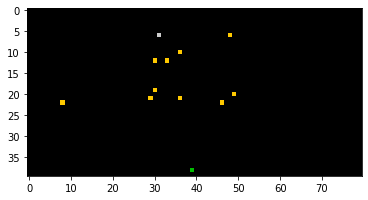

shot 1 with Statsbomb xG = 0.02678909 and predicted xG = [0.00324257] and naive xG = [0.01623939]


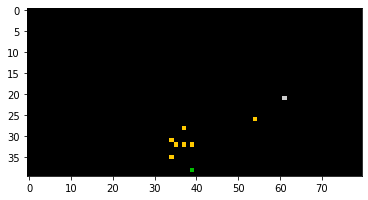

shot 2 with Statsbomb xG = 0.30320165 and predicted xG = [0.27528405] and naive xG = [0.3418094]


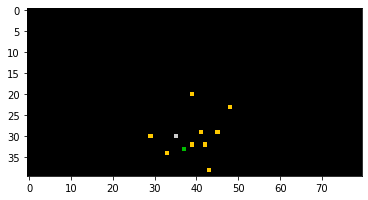

shot 3 with Statsbomb xG = 0.079877675 and predicted xG = [0.15636982] and naive xG = [0.08405253]


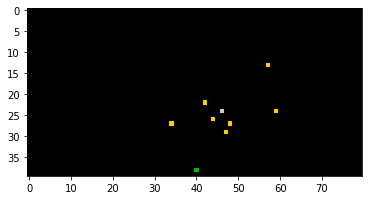

shot 4 with Statsbomb xG = 0.030465763 and predicted xG = [0.02228012] and naive xG = [0.04334265]


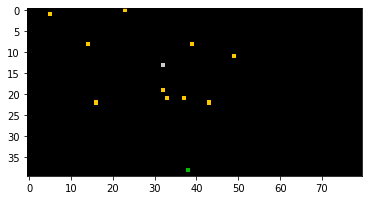

In [ ]:
for i in range(5):  # plot a selection of input images from the test set

    # display original images
    print('shot {0} with Statsbomb xG = {1} and predicted xG = {3} and naive xG = {2}'.format(i, out_test['statsbomb_xg'].iloc[i], y_pred[0][i],y_pred[1][i]))
    plt.imshow(x_test[i, :, :, 0] +(x_test[i, :, :, 1]*0.5) + (x_test[i, :, :, 2]*0.75), cmap='nipy_spectral')  # 4th argument is the channel number so select 0, 1 or 2
    plt.show()

Finally we can check that the model output can actually be interpreted as an xG value. We'll bin the model predictions into 15 bins between 0 and 1. We'll then take the average actual goal outcome of each of those bins. If we plot those average outcomes vs the mid-point of our bins then we'd expect a straight line from 0,0 to 1,1.

We can now see how well the model performs vs this calibration line.

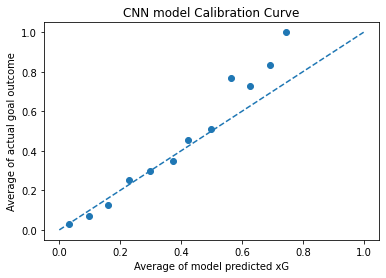

In [ ]:
ccurve = calibration_curve(y_test, y_pred[1], n_bins=15)  # returns true proportion [0] and average predicted prob [1]
plt.scatter(ccurve[1], ccurve[0])
plt.title('CNN model Calibration Curve')
plt.xlabel('Average of model predicted xG')
plt.ylabel('Average of actual goal outcome')
x = [0, 1]
y = [0, 1]
plt.plot(x, y, '--')
plt.show()

Once you're happy with a model and really want to put it through it's paces you can create an interactive web app.

Clone https://github.com/sharmaabhishekk/Interactive-freeze-frames-xg and modify the cosmetic HTML, CSS and Javascript as you wish

Then all you need to do is convert the model into tfjs format. It is a simple one-liner below. 

Once this has run you can drop the output json and bin files into the `models` folder of your web app's directory. And that's it!

In [ ]:
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/convnet_data/models')